In [29]:
# Importe de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score
from xgboost import XGBClassifier
import shap

In [30]:
ruta = "../Rindegastos/bank-full.csv"
df = pd.read_csv(ruta,sep=";")

In [31]:
# Input variables:
#    # bank client data:
#    1 - age (numeric)
#    2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
#                                        "blue-collar","self-employed","retired","technician","services") 
#    3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
#    4 - education (categorical: "unknown","secondary","primary","tertiary")
#    5 - default: has credit in default? (binary: "yes","no")
#    6 - balance: average yearly balance, in euros (numeric) 
#    7 - housing: has housing loan? (binary: "yes","no")
#    8 - loan: has personal loan? (binary: "yes","no")
#    # related with the last contact of the current campaign:
#    9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
#   10 - day: last contact day of the month (numeric)
#   11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
#   12 - duration: last contact duration, in seconds (numeric)
#    # other attributes:
#   13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
#   14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
#   15 - previous: number of contacts performed before this campaign and for this client (numeric)
#   16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

#   Output variable (desired target):
#   17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [32]:
# Estas variables están así, porque son las que actualmente se encuentran en la base de datos, esto funciona para que la ffuncion de validacion funcione.
# En caso de agregar nuevas variables o quitar variables, se requiere hacer la actualización acá
target_col = "y"
num_cols_val = ["age","balance","day","duration","campaign","pdays","previous"
]

cat_cols_val = [
"job","marital","education","default","housing","loan","contact","month","poutcome"
]

In [33]:
# Se crea esta función para validar que los datos que se recibiran a 
# futuro, están en linea con las variables de entreno o de estudio, asi mismo si existen nulos o no, y si es así revisar los casos puntales 
# Se transforma la variable Y categorica a numerical

def validacion(data_frame,num_validacion,cat_validacion):

    data_frame["y"] = (data_frame["y"].astype(str).str.lower() == "yes").astype(int)
    
    required = set([target_col] + num_validacion + cat_validacion)
    if required != set(data_frame.columns):
        faltante = set(data_frame.columns).difference(required)
        sobrante = required.difference(set(data_frame.columns))
        raise ValueError(f"Col faltante: {faltante} , col sobrantes {sobrante}")
    else:
        print("Columnas coinciden: OK")

        
    nulos = data_frame.isnull().sum()
    columnas_con_nulos = nulos[nulos > 0]

    if not columnas_con_nulos.empty:
        raise ValueError(f"Col null: {columnas_con_nulos}")
    else:
        print("No existen columnas con Null: OK")

def dist_numerica(dataframe, target="y"):
    n_cols = 3
    num_cols = dataframe.select_dtypes(include=['int64','float64']).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)
    n_rows = int(np.ceil(len(num_cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        sns.kdeplot(
            data=dataframe,
            x=col,
            hue=target,
            common_norm=False,
            fill=True,
            alpha=0.4,
            ax=axes[i]
        )
        axes[i].set_title(f"Distribución de {col} según {target}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Densidad")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def dist_categorical(dataframe, target="y", n_cols=3):

    cat_cols = dataframe.select_dtypes(include=['object','category','bool']).columns.tolist()
    if target_col in cat_cols:
        cat_cols.remove(target_col)
    n_rows = int(np.ceil(len(cat_cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        dist = (
            dataframe.groupby([col, target])
              .size()
              .reset_index(name="count")
        )
        dist["pct"] = dist.groupby(col)["count"].transform(lambda x: x / x.sum())
        month_order = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]


        # Manejar orden de meses
        if month_order is not None and col == "month":
            dist["month"] = pd.Categorical(dist["month"], categories=month_order, ordered=True)
            x_order = month_order
        else:
            x_order = None

        sns.barplot(
            data=dist,
            x=col,
            y="pct",
            hue=target,
            order=x_order,
            ax=axes[i]
        )
        axes[i].set_title(f"Distribución de {target} por {col}")
        axes[i].set_ylabel("Proporción")
        axes[i].tick_params(axis='x', rotation=45)

    # Eliminar subplots vacíos si los hay
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# No se utiliza directamente un train test, porque no quereremos dividir para hacer predicciones, solo queremos entender el ffniconamiento de estos datos. 
# Eso si, se hace un cross-validation, para mantener consistencia en los datos en caso de que lleguen nuevos
def model_reglog(df, target='y', n_splits=5, random_state=42):

    feature_cols = [c for c in df.columns if c != target]
    X = df[feature_cols].copy()
    y = df[target].values

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()


    pre = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ])

    logit = LogisticRegression(
        max_iter=2000,
        class_weight='balanced'
    )

    pipe = Pipeline([
        ('pre', pre),
        ('clf', logit)
    ])

    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    proba_cv = cross_val_predict(
        pipe, X, y, cv=cv, method='predict_proba'
    )[:, 1]

    auc = roc_auc_score(y, proba_cv)

    pipe.fit(X, y)
    feature_names = pipe.named_steps['pre'].get_feature_names_out()
    coefs = pipe.named_steps['clf'].coef_.ravel()
    coef_df = (
        pd.DataFrame({
            'feature': feature_names,
            'coef': coefs,
            'odds_ratio': np.exp(coefs)
        })
        .sort_values('odds_ratio', ascending=False)
        .reset_index(drop=True)
    )

    return {
        'auc': auc,
        'coef_df': coef_df,
        'pipeline': pipe
    }


def model_xgb(df, target_col, xgb_params=None, plot_shap=True):
    """

    df : pd.DataFrame
        DataFrame con los datos.
    target_col : str
        Nombre de la columna objetivo.
    xgb_params : dict, opcional
        Parámetros para XGBClassifier.
    plot_shap : bool
        Si True, genera el gráfico SHAP summary plot.
    
    Retorna:
    -------
    pipe_xgb : Pipeline
        Pipeline entrenado con preprocesamiento y modelo.
    auc : float
        ROC-AUC promedio en CV.
    ap : float
        Average Precision en CV.
    shap_values : np.array
        Valores SHAP del conjunto de entrenamiento.
    feature_names : list
        Lista de nombres de features tras el preprocesamiento.
    """
    
    # Separar X y y
    
    X = df.drop(columns=target_col)
    y = df[target_col].values

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()


    # Preprocesamiento
    pre_xgb = ColumnTransformer([
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ])
    
    # Parámetros por defecto del XGBClassifier
    if xgb_params is None:
        xgb_params = {
            'n_estimators': 300,
            'max_depth': 4,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'eval_metric': 'logloss',
            'random_state': 42
        }
    
    xgb_model = XGBClassifier(**xgb_params)
    
    # Pipeline
    pipe_xgb = Pipeline([
        ('pre', pre_xgb),
        ('clf', xgb_model)
    ])
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    proba_cv = cross_val_predict(pipe_xgb, X, y, cv=cv, method='predict_proba')[:,1]
    
    auc = roc_auc_score(y, proba_cv)

    
    # Entrenar pipeline completo
    pipe_xgb.fit(X, y)
    X_enc = pipe_xgb.named_steps['pre'].transform(X)
    
    # Obtener nombres de features
    ohe = pipe_xgb.named_steps['pre'].named_transformers_['cat']
    cat_features = ohe.get_feature_names_out(cat_cols)
    feature_names = num_cols + list(cat_features)
    
    # SHAP
    explainer = shap.TreeExplainer(pipe_xgb.named_steps['clf'])
    shap_values = explainer.shap_values(X_enc)
    
    if plot_shap:
        shap.summary_plot(shap_values, X_enc, feature_names=feature_names, sort=True, show=True)
    
    return pipe_xgb, auc,  shap_values


def oof_targeting(
    df,
    pipe,
    target_col="y",
    top_fracs=(0.10, 0.20, 0.30),
    n_calls=10000,
    cv_splits=5
):

    X = df.drop(columns=target_col)
    y = df[target_col].values

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    scores = cross_val_predict(
        pipe, X, y, cv=cv, method="predict_proba"
    )[:, 1]

    auc = roc_auc_score(y, scores)
    ap = average_precision_score(y, scores)

    # Simulacion
    df_sim = df.assign(score_oof=scores)
    baseline = df_sim[target_col].mean()

    rows = []
    for frac in top_fracs:
        thr = df_sim["score_oof"].quantile(1 - frac)
        seg = df_sim[df_sim["score_oof"] >= thr]

        seg_rate = seg[target_col].mean()

        rows.append({
            "segment": f"Top {int(frac*100)}%",
            "baseline_rate": baseline,
            "segment_rate": seg_rate,
            "expected_sales_if_call_n": n_calls * seg_rate,
            "expected_sales_random_n": n_calls * baseline,
            "incremental_sales_n": n_calls * (seg_rate - baseline)
        })

    summary = pd.DataFrame(rows)


    print(f"AUC (OOF) = {auc:.3f} | AP (OOF) = {ap:.3f}")

    top10 = summary.loc[summary["segment"] == "Top 10%"].iloc[0]
    print(
        f"Baseline = {top10['baseline_rate']:.1%}. "
        f"Top 10% → conversión {top10['segment_rate']:.1%}."
    )

    return summary, auc, ap

def perfil_categorico(df_all, df_seg, col, top_k=10):
    base_dist = (
        df_all[col]
        .value_counts(normalize=True)
        .rename("base_pct")
    )
    
    seg_dist = (
        df_seg[col]
        .value_counts(normalize=True)
        .rename("segment_pct")
    )
    
    out = (
        pd.concat([base_dist, seg_dist], axis=1)
        .fillna(0)
        .assign(
            diff_pct=lambda x: x["segment_pct"] - x["base_pct"],
            lift=lambda x: np.where(
                x["base_pct"] > 0,
                x["segment_pct"] / x["base_pct"],
                np.nan
            )
        )
        .sort_values("lift", ascending=False)
        .head(top_k)
    )
    
    return out

def perfil_numerico(df_all, df_seg, col):
    return pd.DataFrame({
        "base_mean": [df_all[col].mean()],
        "segment_mean": [df_seg[col].mean()],
        "base_median": [df_all[col].median()],
        "segment_median": [df_seg[col].median()],
        "diff_mean": [df_seg[col].mean() - df_all[col].mean()]
    }, index=[col])



In [34]:
def main(
    dataframe, 
    target_col="y", 
    drop_cols=None, 
    show_plots=True
):

    # Detectar variables, la idea es poder detectar si se agregan o eliminan nuevas variables antes de que corra todo el proceso.
    # En caso de dque se quiera agregar nuevos datos, se tienen que agregar a la lista

    num_cols = dataframe.select_dtypes(include=["int64","float64"]).columns.tolist()
    cat_cols = dataframe.select_dtypes(include=["object","category","bool"]).columns.tolist()
    
    if target_col in num_cols: 
        num_cols.remove(target_col)
    if target_col in cat_cols: 
        cat_cols.remove(target_col)
    

    # Luego de la validación, se pueden eliminar variables mas adelante

    validacion(dataframe, num_cols_val, cat_cols_val)
    if drop_cols is not None:
        dataframe = dataframe.drop(columns=drop_cols, errors='ignore')

    num_cols = [c for c in num_cols if c not in drop_cols]
    cat_cols = [c for c in cat_cols if c not in drop_cols]

    if show_plots:
        dist_categorical(dataframe, target=target_col)
        dist_numerica(dataframe, target=target_col)
    

    # Se aplica la regresion logistica, esto con la idea de poder modelar relaciones lineales en las variables y determinar la importancia relativa de cada componente.

    results = model_reglog(dataframe, target=target_col)
    print("Coeficientes regresión logística")
    print("Top 10")
    display(results['coef_df'].head(10))
    print("Últimos 10")
    display(results['coef_df'].tail(10))
    

    # Se utiliza XGBoost, para encontrar relaciones no lineales e importancia de los features de cara a la predicción/analisis de la base de datos. 
    # Se utiliza SHAP que es un modelo estadistico para determinar graficamente estos campos

    pipe_xgb, auc_xgb, shap_vals = model_xgb(dataframe, target_col, plot_shap=show_plots)
    print(f"ROC-AUC XGBoost CV: {auc_xgb:.3f}")
    

    # out of fold, o basicamente un cross validation , 
    # esto es para mantener la consistencia en los analisis, tomar los folds y analizar los datos que no están en ese fold, se utiliza pipeline para mantener la estrucura de los datos, normalizacion y categorias

    summary = oof_targeting(dataframe, pipe_xgb, target_col)
    print("\nOOF Targeting Summary:")
    display(summary)
    

    # Crear df_sim para segmentacion del perfil

    df_sim = dataframe.copy()
    if drop_cols is not None:
        df_sim = df_sim.drop(columns=drop_cols, errors='ignore')
    X = df_sim.drop(columns=target_col)
    y = df_sim[target_col].values
    df_sim["score_oof"] = cross_val_predict(
        pipe_xgb, X, y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        method="predict_proba"
    )[:,1]
    
    # Definir segmento Top 10%
    threshold = df_sim["score_oof"].quantile(0.90)
    df_top = df_sim[df_sim["score_oof"] >= threshold].copy()
    

    # Esta seccion es para obtener de forma concreta los mejores clientes en base a los perfiles top 10%
    # CRear los perfiles de las variables nunmericas

    print("\nPerfil numérico del segmento Top 10%:")
    for col in num_cols:
        profile_df = perfil_numerico(df_sim, df_top, col)
        print(f"\nColumna: {col}")
        display(profile_df)
    
 
    # Crear los perfiles con las variables categoricas
 
    print("\nPerfil categórico del segmento Top 10%:")
    for col in cat_cols:
        profile_df = perfil_categorico(df_sim, df_top, col)
        print(f"\nColumna: {col}")
        display(profile_df)
    

    # Histograma del top10%, este grafico representa de forma visual la densidad de los clientes que tienen mayor probabilidad de decir que si, de cara a ofrecer un deposito a plazo 

    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    plt.figure(figsize=(10,5))

    ax = sns.histplot(
        data=df_sim,
        x="score_oof",
        hue="y",
        bins=30,
        stat="density",
        common_norm=False,
        palette={0: "tab:blue", 1: "tab:orange"},
        alpha=0.4
    )

    # Línea del Top 10%
    ax.axvline(threshold, color="red", linestyle="--", linewidth=2)

    # Eliminar leyenda automática de seaborn
    if ax.legend_:
        ax.legend_.remove()

    # Leyenda manual (CORRECTA)
    legend_elements = [
        Patch(facecolor="tab:blue", label="No suscripción (0)", alpha=0.4),
        Patch(facecolor="tab:orange", label="Sí suscripción (1)", alpha=0.4),
        Line2D([0], [0], color="red", linestyle="--", lw=2, label="Umbral Top 10%")
    ]

    ax.legend(
        handles=legend_elements,
        title="Resultado del contacto",
        loc="upper right"
    )

    ax.set_title("Distribución del score por resultado")
    ax.set_xlabel("Probabilidad estimada de suscripción")
    ax.set_ylabel("Densidad")

    plt.tight_layout()
    plt.show()


    
    return {
        "df_sim": df_sim,
        "df_top": df_top,
        "summary_oof": summary,
        "logit_results": results,
        "xgb_pipeline": pipe_xgb,
        "shap_values": shap_vals
    }


Columnas coinciden: OK
No existen columnas con Null: OK


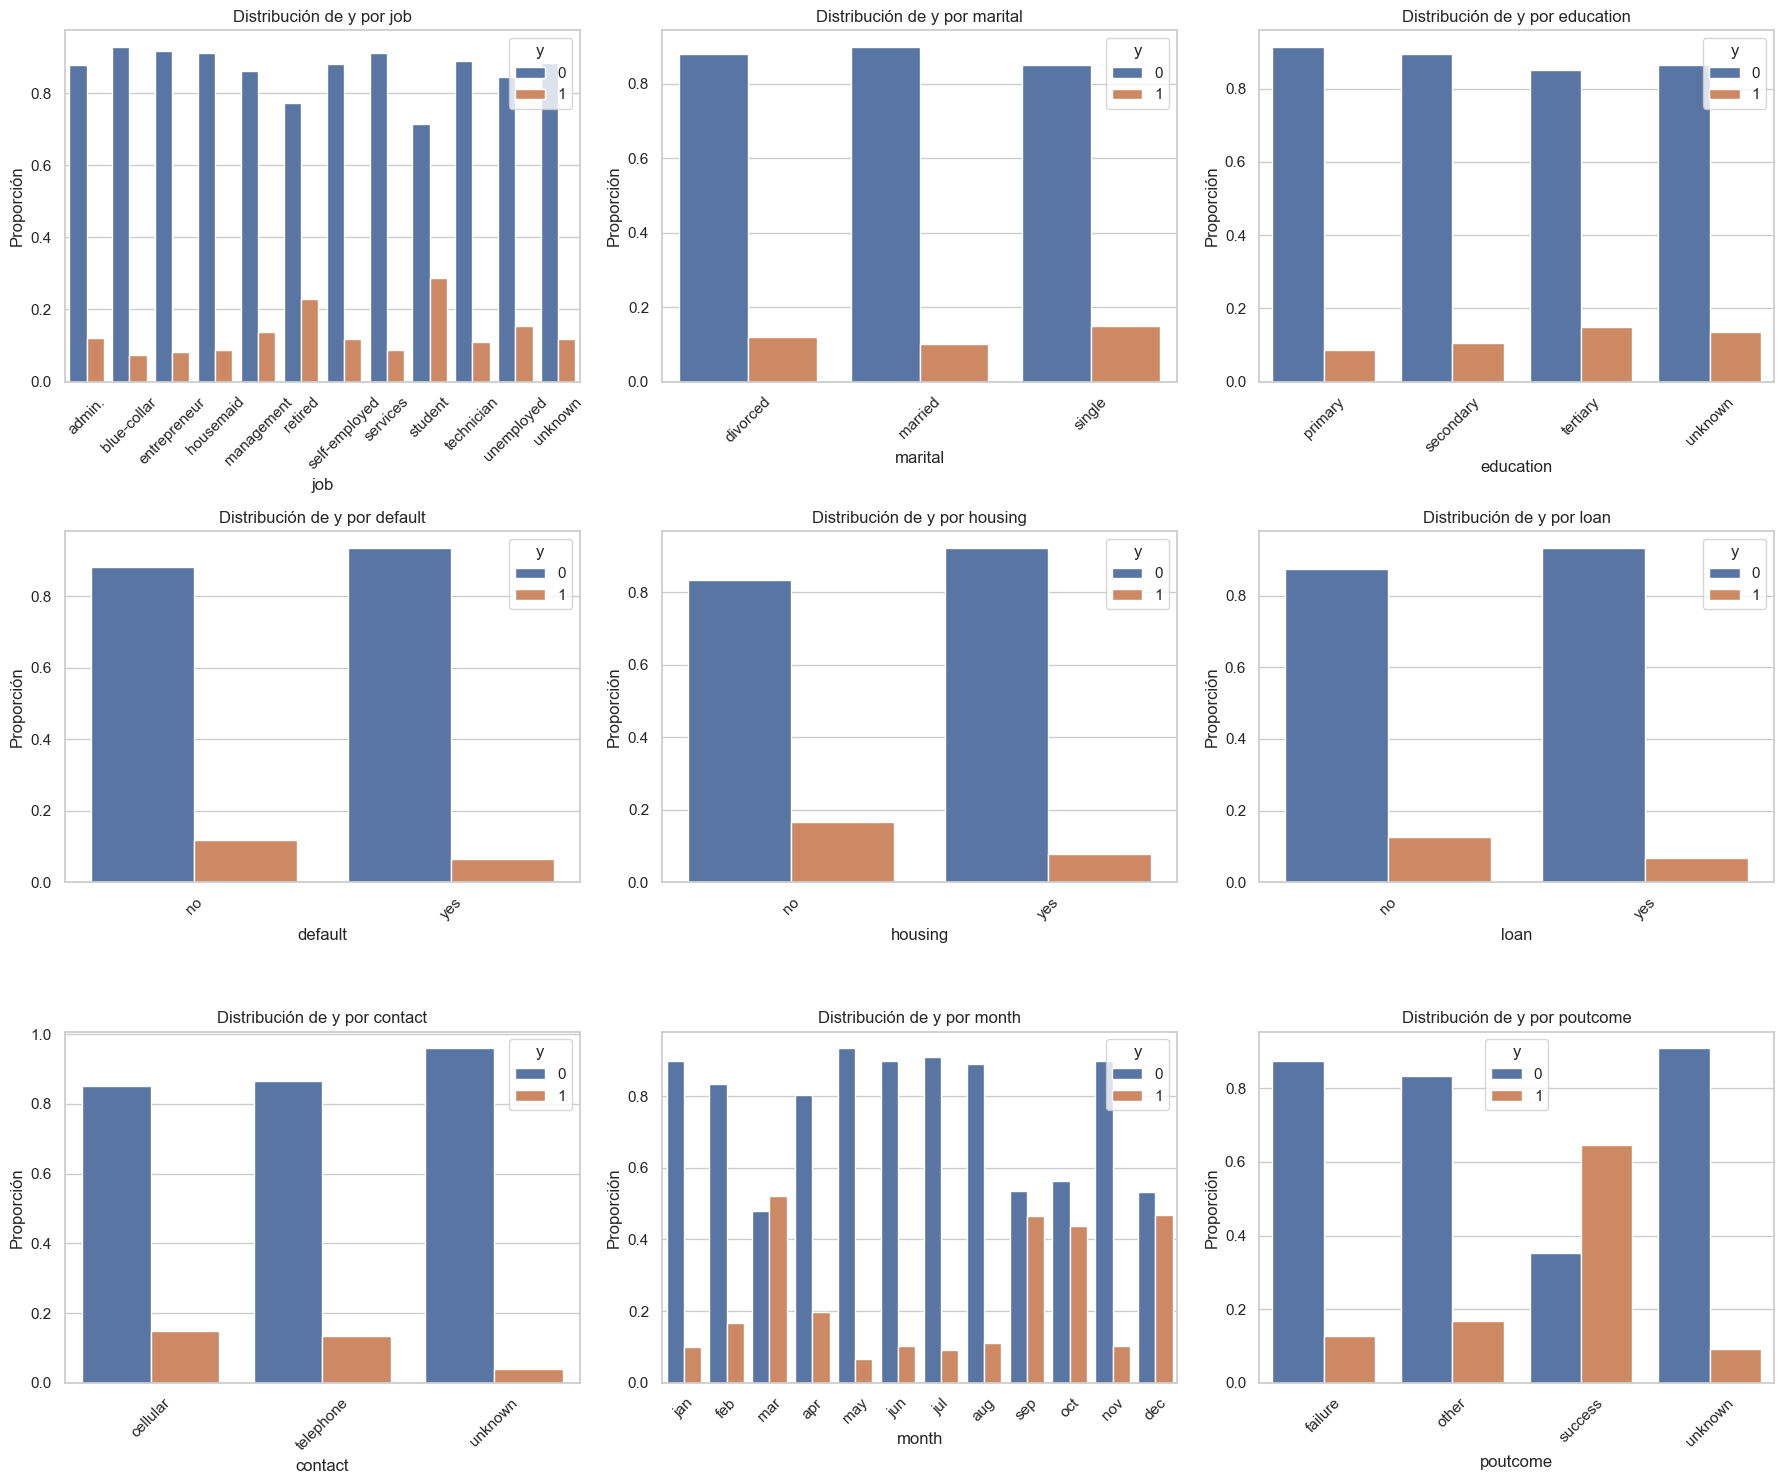

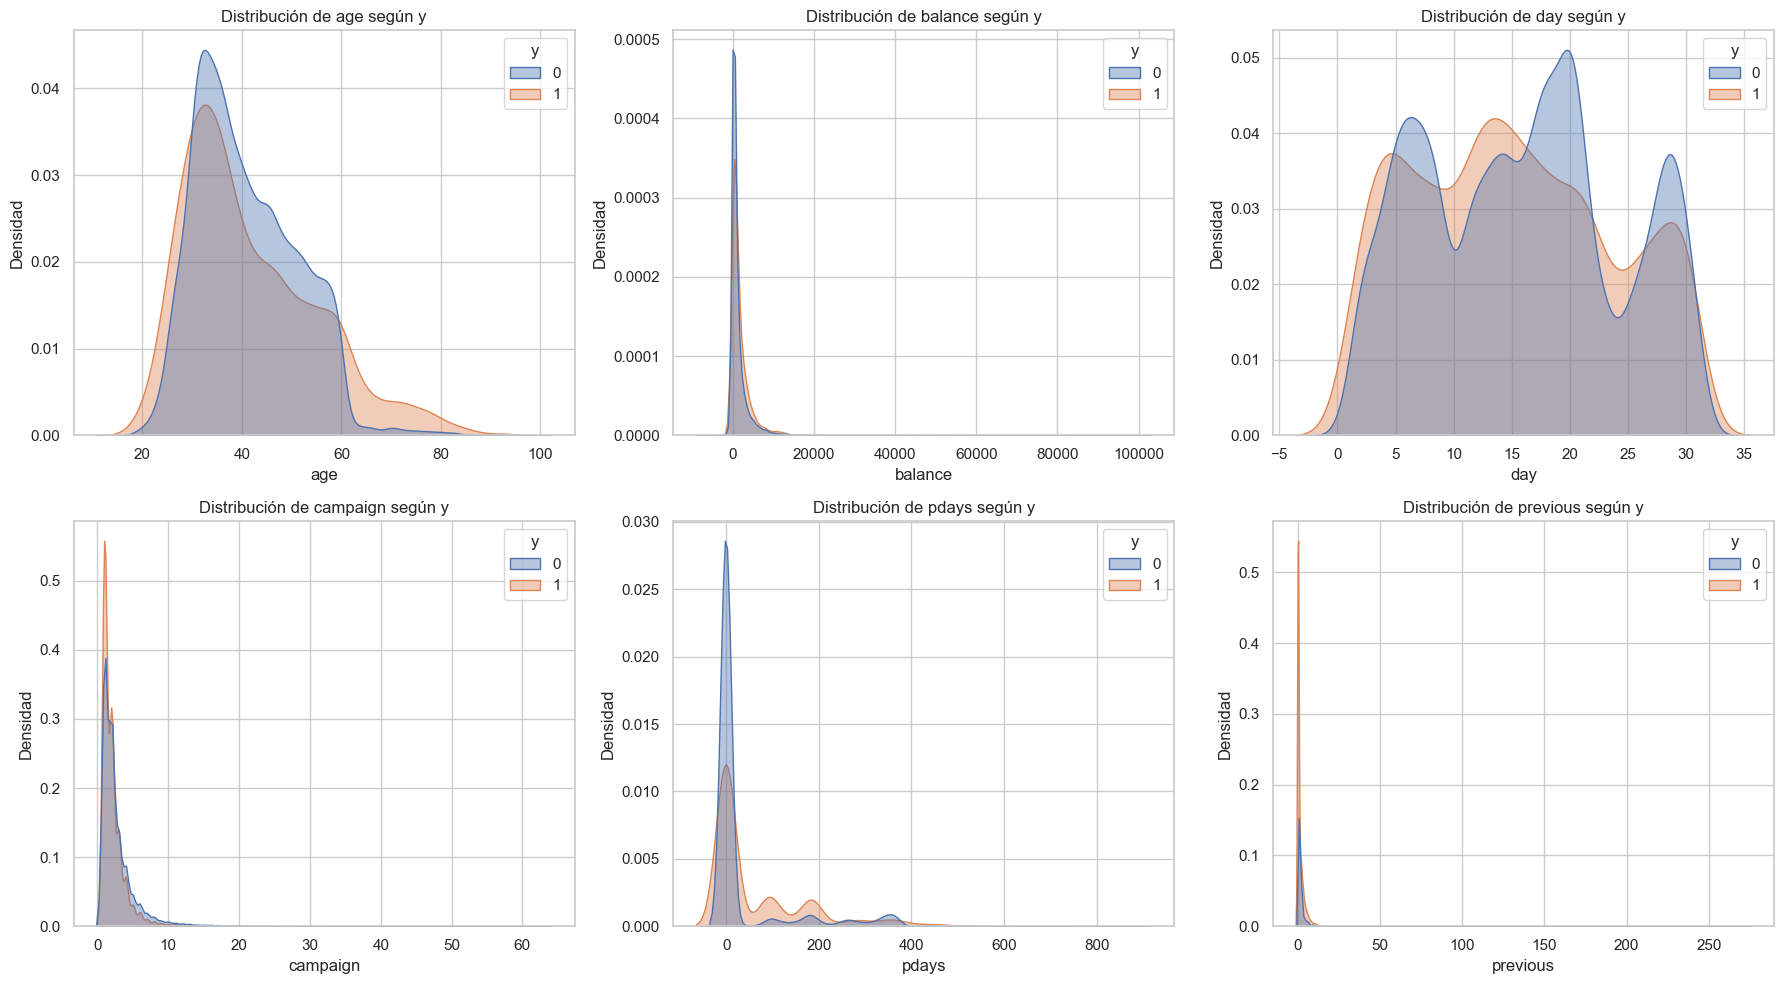

Coeficientes regresión logística
Top 10


,feature,coef,odds_ratio
0,cat__poutcome_success,1.681464,5.373415
1,cat__month_mar,1.280983,3.600175
2,cat__month_oct,0.934589,2.546166
3,cat__month_sep,0.802510,2.231134
4,cat__month_dec,0.784647,2.191632
5,cat__contact_cellular,0.520480,1.682835
6,cat__job_retired,0.495234,1.640883
7,cat__job_student,0.398977,1.490299
8,cat__housing_no,0.281198,1.324716
9,cat__contact_telephone,0.266258,1.305071


Últimos 10


,feature,coef,odds_ratio
40,cat__month_feb,-0.331778,0.717646
41,cat__poutcome_other,-0.382913,0.681872
42,cat__month_may,-0.412537,0.661969
43,cat__poutcome_unknown,-0.569945,0.565556
44,cat__month_jul,-0.601782,0.547835
45,cat__poutcome_failure,-0.633045,0.530973
46,cat__contact_unknown,-0.691176,0.500987
47,cat__month_aug,-0.742251,0.476041
48,cat__month_nov,-0.765629,0.465041
49,cat__month_jan,-1.022157,0.359818


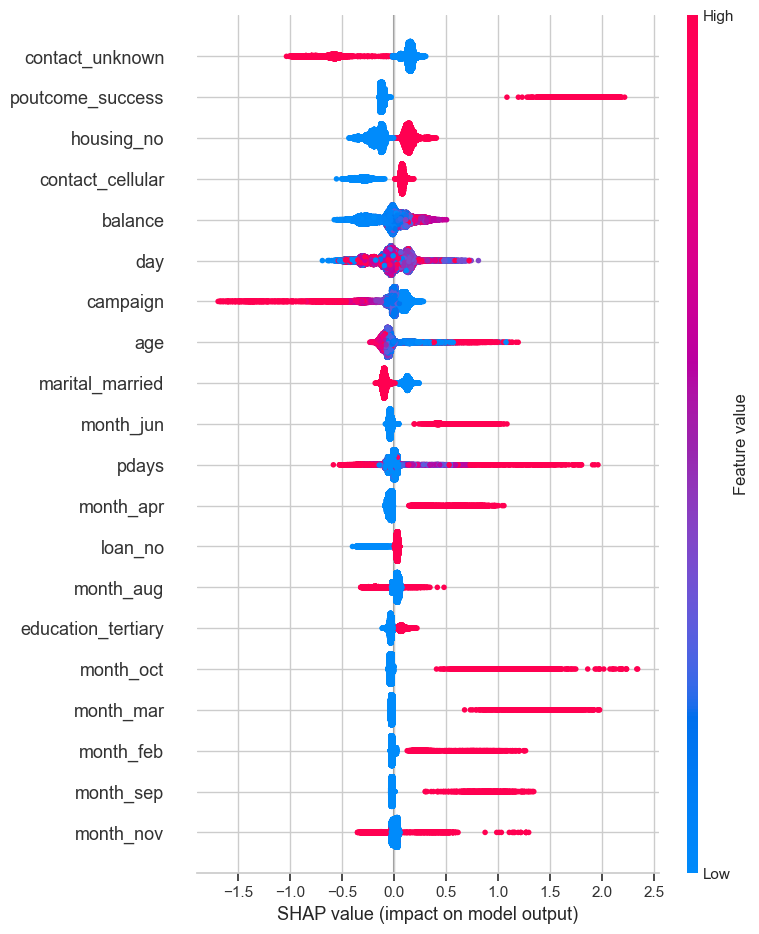

ROC-AUC XGBoost CV: 0.802
AUC (OOF) = 0.802 | AP (OOF) = 0.456
Baseline = 11.7%. Top 10% → conversión 51.2%.

OOF Targeting Summary:


(   segment  baseline_rate  segment_rate  expected_sales_if_call_n  \
 0  Top 10%       0.116985      0.512384               5123.839009   
 1  Top 20%       0.116985      0.364481               3644.808139   
 2  Top 30%       0.116985      0.276541               2765.408434   
 
    expected_sales_random_n  incremental_sales_n  
 0              1169.848046          3953.990963  
 1              1169.848046          2474.960093  
 2              1169.848046          1595.560388  ,
 0.802080610413979,
 0.45584191669308466)


Perfil numérico del segmento Top 10%:

Columna: age


,base_mean,segment_mean,base_median,segment_median,diff_mean
age,40.93621,43.418841,39.0,38.0,2.482631



Columna: balance


,base_mean,segment_mean,base_median,segment_median,diff_mean
balance,1362.272058,2172.025431,448.0,1077.0,809.753374



Columna: day


,base_mean,segment_mean,base_median,segment_median,diff_mean
day,15.806419,15.197258,16.0,15.0,-0.609161



Columna: campaign


,base_mean,segment_mean,base_median,segment_median,diff_mean
campaign,2.763841,1.742813,2.0,1.0,-1.021028



Columna: pdays


,base_mean,segment_mean,base_median,segment_median,diff_mean
pdays,40.197828,97.889872,-1.0,80.0,57.692044



Columna: previous


,base_mean,segment_mean,base_median,segment_median,diff_mean
previous,0.580323,1.749668,0.0,1.0,1.169345



Perfil categórico del segmento Top 10%:

Columna: job


,base_pct,segment_pct,diff_pct,lift
job,,,,
student,0.020747,0.085139,0.064392,4.103661
retired,0.050076,0.161875,0.111799,3.232572
unemployed,0.028820,0.040027,0.011206,1.388826
unknown,0.006370,0.007961,0.001591,1.249751
management,0.209197,0.257187,0.047990,1.229402
admin.,0.114375,0.124724,0.010349,1.090481
self-employed,0.034925,0.036267,0.001342,1.038425
technician,0.168034,0.142857,-0.025177,0.850166
housemaid,0.027427,0.021451,-0.005976,0.782102



Columna: marital


,base_pct,segment_pct,diff_pct,lift
marital,,,,
single,0.282896,0.396064,0.113168,1.400034
divorced,0.115171,0.102831,-0.012340,0.892851
married,0.601933,0.501106,-0.100827,0.832494



Columna: education


,base_pct,segment_pct,diff_pct,lift
education,,,,
unknown,0.041074,0.060372,0.019297,1.469820
tertiary,0.294198,0.428350,0.134152,1.455992
secondary,0.513194,0.411322,-0.101871,0.801495
primary,0.151534,0.099956,-0.051578,0.659626



Columna: default


,base_pct,segment_pct,diff_pct,lift
default,,,,
no,0.981973,0.999558,0.017584,1.017907
yes,0.018027,0.000442,-0.017584,0.024535



Columna: housing


,base_pct,segment_pct,diff_pct,lift
housing,,,,
no,0.444162,0.816453,0.372291,1.838188
yes,0.555838,0.183547,-0.372291,0.330217



Columna: loan


,base_pct,segment_pct,diff_pct,lift
loan,,,,
no,0.839774,0.961964,0.12219,1.145504
yes,0.160226,0.038036,-0.12219,0.237391



Columna: contact


,base_pct,segment_pct,diff_pct,lift
contact,,,,
telephone,0.064276,0.090226,0.025949,1.403712
cellular,0.647741,0.899381,0.251640,1.388489
unknown,0.287983,0.010394,-0.277589,0.036091



Columna: month


,base_pct,segment_pct,diff_pct,lift
month,,,,
mar,0.010551,0.097744,0.087194,9.264403
sep,0.012807,0.102167,0.089361,7.977687
oct,0.016323,0.123618,0.107294,7.573018
dec,0.004733,0.034719,0.029986,7.334988
apr,0.064851,0.159885,0.095034,2.465403
feb,0.058592,0.082264,0.023673,1.404024
jun,0.118135,0.135338,0.017203,1.145625
jan,0.031032,0.026979,-0.004053,0.869392
nov,0.087810,0.058824,-0.028987,0.669892



Columna: poutcome


,base_pct,segment_pct,diff_pct,lift
poutcome,,,,
success,0.033421,0.316232,0.282811,9.462048
other,0.040698,0.078947,0.038249,1.939831
failure,0.108403,0.141751,0.033349,1.307636
unknown,0.817478,0.463069,-0.354409,0.566461


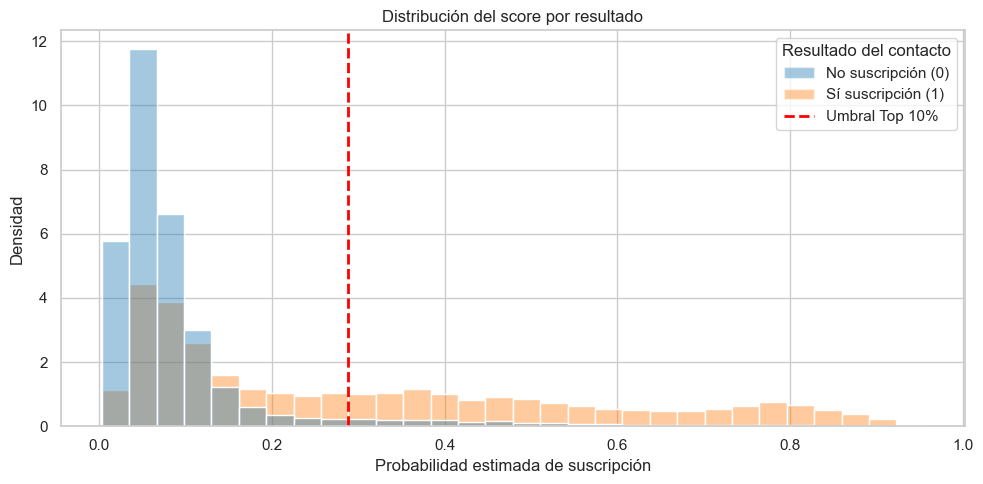

In [35]:
# Llamada al main
resultados = main(
    dataframe=df,       # tu DataFrame
    target_col="y",     # columna objetivo
    drop_cols="duration",     # None, Columnas que quieras eliminar (opcional), eliminamos esta variables por el ehecho de que estamos buscando segmentar clientes ANTES de llamarlos, y como duration se conoce después de la llamada, 
                              # No aporta un valor operacional adecuado al analisis que estamos haciendo
    show_plots=True     # True/False para ver gráficos
)

# Acceder a resultados:
df_sim = resultados["df_sim"]
df_top = resultados["df_top"]
summary_oof = resultados["summary_oof"]
